<h1> <font color=steelblue>Constraining Remotely-Sensed River Discharge Estimation Using Reach-Scale Geomorphology</font></h1>
<br>
    Craig Brinkerhoff <br>
    Colin Gleason <br>
    Peirong Lin <br>
    Konstantinos Andreadis

<h3><font color=darkcyan> What? </font></h3>
<h5>
    Can we produce better discharge estimates by incorporating river physics and 'types' of river physics into BAM?
</h5>
    <br><br>
    1) Introduce more physically-representative river physics into BAM likelihood function <b>DONE</b><br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.5) Is a physically-based manning-amhg switch better than the previously defined mathmatical one? <b>DONE </b><br>
        &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1.75) Space-varying and Space/Time-varying Manning's n yielding improvement?? <b>DONE </b><br><br>
    2) Introduce priors that are trained on a larger, more physically-representative training set of hydraulics measurements <b> DONE </b><br>
    3) Constrain old and new priors by river type via a river classification framework built on training set <b>DONE </b> <br>
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  1) test class-binned Wb, Db, and A0 <b>DONE-doing moving forward</b><br>
      &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  2) test more/less classes <b>DONE- 8 is most I can do before notable class overlap (also best result...)</b><br>
            &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  3) Extrapolate to wide rivers <b>DONE</b><br>
    <br>
    4) Machine Learning Approaches <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  1) straight k-means on training data and mapped to pepsi using river width <b>DONE- worse </b><br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  2) DBSCAN <b>DONE </b><br>

<h3><font color=darkcyan> USGS NHD 2.1 </font></h3>

<p> This work is performed on a dataset of USGS field mesurements of channel hydraulics originally collected by Barber and Gleason (2018) joined to NHD, resulting in an expanded version of the dataset used in Brinkerhoff, et al. (2019)
    <br><br>
    Stream Order <br>
    Slope <br>
    Distance Downstream <br>
    Maximum Grain Size Entrained (Henderson, 1966) <br>
    Shear Stress <br>
    Froude Number <br>
    Drainage Area <br>
    Unit Stream Power <br>
    Channel Shape <br>
    Channel Width <br>
    Channel Depth <br>
    Channel Velocity <br>
    Bankfull Shape <br>
    Bankfull Width <br>
    Bankfull Depth <br>
    Bankfull Velocity <br>
    Reach Type (i.e. perennial, intermittent, lake/wetland/reservoir, canal, or connector).<br>
    Sinuosity
    <br><br>It must be stressed that these joined variables exist at the reach-scale, while the field measurements exist at the cross-section scale. Also, these results are only reflective of the hydrology/geomorphology of river reaches measured by the USGS, generally at streamagauges.</p>

<h3><font color=darkcyan> Lakes/Reservoirs Preprocessing on NHD </font></h3>
<p> NHD for some reason has assigned many main stem or close-to-main stem reaches as artifical paths and not rivers.  Artifical paths are only supposed to be for throughflow lines in lakes/wetlands/reservoirs.
<br><br>
So, I identified reaches classed as 'ArtificalPath' that had no corresponding waterbodyID in the lakes dataset, assumed main stem reaches are perrenial, and reclassified those reaches as perrenial rivers.
<br><br> Canals and NHD's 'connectors' are listed as Artifical Channels.  'Connectors' are reaches the NHD had to add to make the network continuous in some places (i.e. through dams)
<br><br>
I am using the NHD's defintion of river intermittncy.  It's unclear how they designate perrenial/intermittent/ephemeral (no ephemeral reaches had measurements on them)
</p>

<h3><font color=darkcyan> Functions </font></h3>

In [1]:
#AHG exp function
def regress(data, yvar, xvars):
    Y = np.log(data[yvar])
    X = np.log(data[xvars])
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params[0] #only get exp

#AHG int function
def regress2(data, yvar, xvars):
    Y = np.log(data[yvar])
    X = np.log(data[xvars])
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params[1] #only get int

#bankfull hydraulics function
def calculate_bankful(df, colname, retPeriod):
    # sort data smallest to largest
    sorted_data = df.sort_values(by=colname, ascending = False)
    # count total obervations
    n = sorted_data.shape[0]
    # add a numbered column 1 -> n to use in return calculation for rank
    sorted_data.insert(0, 'rank', range(1, 1 + n))
    #find desired rank
    desiredRank = (n+1)/retPeriod
    desiredRank = round(desiredRank)
    #get variable with desired rank
    output = sorted_data.loc[sorted_data['rank'] == desiredRank, colname]
    return(output)

#AHG r2 function
def regress3(data, yvar, xvars):
    Y = np.log(data[yvar])
    X = np.log(data[xvars])
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.rsquared #only get r2

<h3><font color=darkcyan> Data Wranglin' & Cleanin' </font></h3>

In [2]:
import pandas as pd
import os
import numpy as np
import scipy.stats.mstats as sp
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import math
from IPython.display import display, HTML
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model
from pandas.plotting import scatter_matrix
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from bokeh.plotting import figure, show, output_notebook
from bokeh.tile_providers import CARTODBPOSITRON, STAMEN_TONER_BACKGROUND
from ast import literal_eval

#set working directory
os.chdir("C:\\Users\\cbrinkerhoff\\Box Sync\\Ongoing Projects\\geomorph_class\\")

#load in barber dataset
Hydroshortened = pd.read_csv('Barber_rivers.csv', low_memory=False, encoding='latin-1')

#NHD 2.1 flowlines (with USGS gauges snapped to them) and lakes
med_NHD = pd.read_csv('NHD_med_res.csv', low_memory=False, encoding='latin-1')
med_NHD_lakes = pd.read_csv('med_NHD_lakes.csv', low_memory=False, encoding='latin-1')

#NHD sinuosity from  Wieczorek, M.E., Jackson, S.E., and Schwarz, G.E., 2018, Select Attributes for NHDPlus Version 2.1 Reach Catchments and Modified Network Routed Upstream Watersheds for the Conterminous United States: U.S. Geological Survey data release, https://doi.org/10.5066/F7765D7V. 
sinuosityCONUS = pd.read_csv('Sinuousity_CONUS.txt', delimiter=',')

Hydroshortened = pd.merge(Hydroshortened, med_NHD[['SOURCE_FEA', 'COMID', 'SLOPE', 'StreamOrde', 'ArbolateSu', 'Measure', 'LENGTHKM', 'LatSite', 'LonSite', 'FTYPE', 'FCODE', 'DASqKm', 'Tidal', 'WBAREACOMI', 'TOTMA']],left_on='site_no', right_on='SOURCE_FEA')
Hydroshortened = pd.merge(Hydroshortened, sinuosityCONUS, left_on='COMID', right_on='COMID')

In [3]:
#get depth
Hydroshortened['chan_depth'] = Hydroshortened['chan_area']/Hydroshortened['chan_width']

#cleaning NA values and hydraulics below 0
Hydroshortened = Hydroshortened[Hydroshortened['chan_width'] > 0]
Hydroshortened = Hydroshortened[Hydroshortened['chan_depth'] > 0]
Hydroshortened = Hydroshortened[Hydroshortened['chan_discharge'] > 0]
Hydroshortened = Hydroshortened[Hydroshortened['measured_rating_diff'] != 'Poor']
Hydroshortened = Hydroshortened[Hydroshortened['measured_rating_diff'] != 'POOR']

Hydroshortened = Hydroshortened[Hydroshortened['chan_width'].notnull()]
Hydroshortened = Hydroshortened[Hydroshortened['chan_depth'].notnull()]
Hydroshortened = Hydroshortened[Hydroshortened['chan_discharge'].notnull()]
Hydroshortened = Hydroshortened[Hydroshortened['chan_width'].notna()]
Hydroshortened = Hydroshortened[Hydroshortened['chan_depth'].notna()]
Hydroshortened = Hydroshortened[Hydroshortened['chan_discharge'].notna()]

#convert needed units to metric
Hydroshortened['chan_width'] = Hydroshortened['chan_width']*0.305
Hydroshortened['chan_depth'] = Hydroshortened['chan_depth']*0.305
Hydroshortened['chan_velocity'] = Hydroshortened['chan_velocity']*0.305
Hydroshortened['chan_discharge'] = Hydroshortened['chan_discharge']*0.028

Hydroshortened['n'] = ((Hydroshortened['chan_depth'])**(2/3)*Hydroshortened['SLOPE']**(1/2))/Hydroshortened['chan_velocity']
Hydroshortened['shearStress'] = 9.81*Hydroshortened['chan_depth']*Hydroshortened['SLOPE']
Hydroshortened['Fb'] = Hydroshortened['chan_velocity']/((Hydroshortened['chan_depth']*9.81)**(1/2))
Hydroshortened['minEntrain'] = 11*Hydroshortened['chan_depth']*Hydroshortened['SLOPE']

#A0- median not minimum
Hydroshortened = Hydroshortened.join(Hydroshortened.groupby('site_no')['chan_area'].agg(['median']), on='site_no')
Hydroshortened = Hydroshortened.rename(columns={"median": "A0"})

#number of measurements at-a-station
groupSize = Hydroshortened.groupby('site_no').size().to_frame()
Hydroshortened = Hydroshortened.merge(groupSize, on='site_no')

#AHG parameters
b_temp = Hydroshortened.groupby('site_no').apply(regress, 'chan_width', ['chan_discharge']).to_frame()
a_temp = Hydroshortened.groupby('site_no').apply(regress2, 'chan_width', ['chan_discharge']).to_frame()
f_temp = Hydroshortened.groupby('site_no').apply(regress, 'chan_depth', ['chan_discharge']).to_frame()
c_temp = Hydroshortened.groupby('site_no').apply(regress2, 'chan_depth', ['chan_discharge']).to_frame()
m_temp = Hydroshortened.groupby('site_no').apply(regress, 'chan_velocity', ['chan_discharge']).to_frame()
k_temp = Hydroshortened.groupby('site_no').apply(regress2, 'chan_velocity', ['chan_discharge']).to_frame()

b_temp = b_temp.rename(columns={0:'b'})
Hydroshortened =  pd.merge(Hydroshortened, b_temp, on='site_no')

a_temp = a_temp.rename(columns={0:'loga'})
Hydroshortened =  pd.merge(Hydroshortened, a_temp, on='site_no')

c_temp = c_temp.rename(columns={0:'logc'})
Hydroshortened =  pd.merge(Hydroshortened, c_temp, on='site_no')

f_temp = f_temp.rename(columns={0:'f'})
Hydroshortened =  pd.merge(Hydroshortened, f_temp, on='site_no')

k_temp = k_temp.rename(columns={0:'logk'})
Hydroshortened =  pd.merge(Hydroshortened, k_temp, on='site_no')

m_temp = m_temp.rename(columns={0:'m'})
Hydroshortened =  pd.merge(Hydroshortened, m_temp, on='site_no')

#Calculate some more variables
Hydroshortened['r'] = Hydroshortened['f']/Hydroshortened['b']
Hydroshortened['unitPower'] = (998*9.8*Hydroshortened['chan_discharge']*Hydroshortened['SLOPE'])/Hydroshortened['chan_width']
Hydroshortened['DistDwnstrm'] = Hydroshortened['ArbolateSu']-((Hydroshortened['Measure']/100)*Hydroshortened['LENGTHKM'])
Hydroshortened['chan_material'] = np.where(Hydroshortened['chan_material'] == 'silt', 'SILT', Hydroshortened['chan_material'])
Hydroshortened['chan_material_index'] = np.where(Hydroshortened['chan_material'] == 'BLDR', 1,
                                                np.where(Hydroshortened['chan_material'] == 'GRVL', 2,
                                                        np.where(Hydroshortened['chan_material'] == 'SAND', 3,
                                                                np.where(Hydroshortened['chan_material'] == 'SILT', 4,
                                                                        np.where(Hydroshortened['chan_material'] == 'UNSP', 5,5)))))

Hydroshortened['FCODEnorm'] = np.where(Hydroshortened['FCODE'] == 33400, 1, #connectors or canals
                                                np.where(Hydroshortened['FCODE'] == 33600, 1, #connectors or canal
                                                        np.where(Hydroshortened['FCODE'] == 46003, 2, #intermittent river
                                                                np.where(Hydroshortened['FCODE'] == 46006, 3, #perienial river
                                                                        np.where(Hydroshortened['WBAREACOMI'].isin(med_NHD_lakes['COMID']), 4,3))))) #lake if also in lakes dataset, otherwise its a main stem river or tidal reach and can be reclassified as perrenial river (basically....)

Hydroshortened['FTYPE'] = np.where(Hydroshortened['FCODE'] == 33400, 'ArtificalChannel', #connector or canal
                                                np.where(Hydroshortened['FCODE'] == 33600, 'ArtificalChannel', #connector or canal
                                                        np.where(Hydroshortened['FCODE'] == 46003, 'IntermittentRiver', #intermittent river
                                                                np.where(Hydroshortened['FCODE'] == 46006, 'PerennialRiver', #perienial river
                                                                        np.where(Hydroshortened['WBAREACOMI'].isin(med_NHD_lakes['COMID']), 'Lake/Reservoir/Wetland','PerennialRiver')))))

#Bankfull hydraulics Using 2 yr return period
bank_width = Hydroshortened.groupby('site_no').apply(calculate_bankful, 'chan_width', 2).to_frame()
bank_width = bank_width.rename(columns={'chan_width':'bank_width'})
Hydroshortened =  pd.merge(Hydroshortened, bank_width, on='site_no')

bank_depth = Hydroshortened.groupby('site_no').apply(calculate_bankful, 'chan_depth', 2).to_frame()
bank_depth = bank_depth.rename(columns={'chan_depth':'bank_depth'})
Hydroshortened =  pd.merge(Hydroshortened, bank_depth, on='site_no')

bank_Q = Hydroshortened.groupby('site_no').apply(calculate_bankful, 'chan_discharge', 2).to_frame()
bank_Q = bank_Q.rename(columns={'chan_discharge':'bank_Q'})
Hydroshortened =  pd.merge(Hydroshortened, bank_Q, on='site_no')

<h4> <font color=darkolivegreen>Filter sites w/ impossible AHG</font> </h4>

In [4]:
Hydroshortened = Hydroshortened[Hydroshortened['b'] > 0]
Hydroshortened = Hydroshortened[Hydroshortened['b'] < 1]
Hydroshortened = Hydroshortened[Hydroshortened['f'] > 0]
Hydroshortened = Hydroshortened[Hydroshortened['f'] < 1]
Hydroshortened = Hydroshortened[Hydroshortened['m'] > 0]
Hydroshortened = Hydroshortened[Hydroshortened['m'] < 1]

<h4> <font color=darkolivegreen>Width AMHG</font> </h4>

<h4> <font color=darkolivegreen>Resulting Dataset Size and Spatial Distribution</font> </h4>

In [5]:
print('\033[1m' + "# measurements:")
display(len(Hydroshortened.index))

print('\033[1m' + "# cross-sections:")

display(Hydroshortened.groupby('site_no').ngroups)

print('\033[1m' + "# rivers:")
display(Hydroshortened.groupby('river_name').ngroups)

#Hydroshortened.to_csv('for_dbscan.csv')

# measurements:


372109

# cross-sections:


1444

# rivers:


190

In [14]:
from bokeh.plotting import figure, save
from bokeh.tile_providers import CARTODBPOSITRON, STAMEN_TONER_BACKGROUND

#convert lat/long to web mercator function
def merc(Coords):
    Coordinates = literal_eval(Coords)
    lat = Coordinates[0]
    lon = Coordinates[1]
    
    r_major = 6378137.000
    x = r_major * math.radians(lon)
    scale = x/lon
    y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + 
        lat * (math.pi/180.0)/2.0)) * scale
    return (x, y)

#convert Hydroshortened lat/long to mercator
Hydroshortened['latlong'] = '(' + Hydroshortened["LatSite"].map(str) + ', ' + Hydroshortened["LonSite"].map(str) + ')'

Hydroshortened['long_merc'] = Hydroshortened['latlong'].apply(lambda x: merc(x)[0])
Hydroshortened['lat_merc'] = Hydroshortened['latlong'].apply(lambda x: merc(x)[1])

grouped = Hydroshortened.groupby('site_no').mean()

#plot basemap
p = figure(x_range=(-14026255, -7347086), y_range=(2999080, 7170156),
           x_axis_type="mercator", y_axis_type="mercator", title="Field-Measurement Cross-Sections", plot_width=900)
p.add_tile(STAMEN_TONER_BACKGROUND)

p.circle(x = grouped['long_merc'],
         y = grouped['lat_merc'],
        size=3,
        fill_color='darkgreen')

output_notebook()
show(p)

#save to file
from bokeh.io import export_png
export_png(p, filename="C:\\Users\\cbrinkerhoff\\Box Sync\\Ongoing Projects\\geomorph_class\\Figures\\map.png")

Loading BokehJS ...

'C:\\Users\\cbrinkerhoff\\Box Sync\\Ongoing Projects\\geomorph_class\\Figures\\map.png'

<h3><font color=darkcyan> Calculate Global Priors </font></h3>

<h4> <font color=darkolivegreen>Calculate Global Hat Functions</font> </h4>

In [ ]:
Hydroshortened['logchan_width'] = np.log(Hydroshortened['chan_width'])

stdWdths = Hydroshortened.groupby('site_no')['logchan_width'].std().to_frame()
stdWdths = stdWdths.rename(columns={'logchan_width':'stdWdth'})
meanWdths = Hydroshortened.groupby('site_no')['logchan_width'].mean().to_frame()
meanWdths = meanWdths.rename(columns={'logchan_width':'meanWdths'})

Hydroshortened =  pd.merge(Hydroshortened, stdWdths, on='site_no')
Hydroshortened =  pd.merge(Hydroshortened, meanWdths, on='site_no')

<h4> <font color=darkolivegreen>Extract Braided River Prior Information</font> </h4>

<h3><font color=darkcyan> Classifying by River Type </font></h3>

<h4> <font color=darkolivegreen>Supervised: PCA-Based 'Fluvial Index' </font></h4>

<p>
    5 PCs were ultimately selected for analysis as they explain ~75% of variance in the dataset.
</p>
<p>
   The top weighted metrics for PC1 are unit power, slope, shear stress, and minimum entrained grain size.  For PC2 they are stream order, distance downstream, and drainage area.  For PC3 it is velocity and froude number,  for PC4 it is residence time, depth, and waterbody type, and PC5 is channel shape.
    <br><br>
    <b>The main axes of geomorphic variation across these rivers have thus been termed 'Sediment Transport', 'Longitunidal Location', 'Flow State', 'waterbody type', and 'Channel Shape'.</b>
</p>
<br>
<p>
    I then use a 'geomorphic index' which is just a sum of the top 5 PC values for each measurement.  This is purposefully not weighted by the relative importance of each PC (i.e. they're all weighted equally).  Classes are then determined by breaking the measurements along the deciles for the distribution
</p>
<br>
<b>
    This largely amounts to a classification of 'river magnitude'
</b>

<h4><font color=darkolivegreen>Unsupervised: KMeans </font> </h4>
<br><br>
Kmeans sets intial 'cluster means' given clusters n and then iteraively groups points until cluster means are sufficiently different

<h4> <font color=darkolivegreen> DBSCAN Clustering </font></h4>
<br><br>
DBSCAN, unlike KMeans, doesn't assume convex shape for clusters.  Setting a max radius for clusters epislon and a minimum cluster size, it finds clusters amongst noisy points outside the epislon of all clusters

In [14]:
data = pd.read_csv('C:\\Users\\cbrinkerhoff\\Box Sync\\Ongoing Projects\\geomorph_class\\dbscan\\clustered_ep_20.csv', low_memory=False)
data['logA0'] = np.log(data['A0'])
data['logr'] = np.log(data['r'])
data['logn'] = np.log(data['n'])
data['logWb'] = np.log(data['bank_width'])
data['logDb'] = np.log(data['bank_depth'])
data['logQb'] = np.log(data['bank_Q'])
data['log10De'] = np.log10(data['minEntrain'])

data['logchan_width'] = np.log(data['chan_width'])

stdWdths = data.groupby('site_no')['logchan_width'].std().to_frame()
stdWdths = stdWdths.rename(columns={'logchan_width':'stdWdth'})
meanWdths = data.groupby('site_no')['logchan_width'].mean().to_frame()
meanWdths = meanWdths.rename(columns={'logchan_width':'meanWdths'})

data =  pd.merge(data, stdWdths, on='site_no')
data =  pd.merge(data, meanWdths, on='site_no')

In [46]:
data['logSLOPE'] = np.log(data['SLOPE'])
data['log10SLOPE'] = np.log10(data['SLOPE'])
data['log10n'] = np.log10(data['n'])

#For non time-varying parameters, need a dataset of only one value per station
cluster0 = data[data['cluster'] == 7]

resultB = sm.OLS(cluster0['b'], sm.add_constant(cluster0['stdWdth'])).fit()
resultA0 = sm.OLS(cluster0['logA0'], sm.add_constant(cluster0[['meanWdths','stdWdth']])).fit()
resultWb = sm.OLS(cluster0['logWb'], sm.add_constant(cluster0[['meanWdths']])).fit()
resultDb = sm.OLS(cluster0['logDb'], sm.add_constant(cluster0[['meanWdths', 'stdWdth']])).fit()
result_r = sm.OLS(cluster0['logr'], sm.add_constant(cluster0[['meanWdths', 'stdWdth']])).fit()
resultQb = sm.OLS(cluster0['logQb'], sm.add_constant(cluster0[['meanWdths']])).fit()
resultDe = sm.OLS(cluster0['log10De'], sm.add_constant(cluster0[['log10SLOPE']])).fit()
resultN = sm.OLS(cluster0['logn'], sm.add_constant(cluster0[['logSLOPE']])).fit()

#get residual standard errors --> SD for hat funtions in BAM
sdWb = np.sqrt(resultWb.scale)
sdDb = np.sqrt(resultDb.scale)
sdR = np.sqrt(result_r.scale)
sdN = np.sqrt(resultN.scale)
sdB = np.sqrt(resultB.scale)
sdA0 = np.sqrt(resultA0.scale)

priorsSD = pd.DataFrame(index=['Wb','Db','r','n', 'A0', 'b'])
priorsSD['SD'] = (sdWb, sdDb, sdR, sdN, sdA0, sdB)
priorsSD.to_csv('priorSDsDBSCAN_7.csv')

In [52]:
resultN.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   logn   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                 5.765e+04
Date:                Fri, 22 Nov 2019   Prob (F-statistic):               0.00
Time:                        17:24:10   Log-Likelihood:                -3198.1
No. Observations:               13217   AIC:                             6400.
Df Residuals:                   13215   BIC:                             6415.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2997      0.017     17.606      0.000       0.266       0.333
logSLOPE       0.4281      0.002    240.098      0.000       0.425       0.432
==============================================================================
Omnibus:                     2702.311   Durbin-Watson:                   0.277
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11933.962
Skew:                           0.939   Prob(JB):                         0.00
Kurtosis:                       7.259   Cond. No.                         61.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
#extract class distributions
#maps class to river based on 'closest' median cross-sectional average width of each class
binnedMeanWdths = data.groupby('cluster')['logchan_width'].describe()

#save prior distribution parameters
priorWbClassDBSCAN = data.groupby('cluster')['logWb'].describe()
priorDbClassDBSCAN = data.groupby('cluster')['logDb'].describe()
prior_rClassDBSCAN = data.groupby('cluster')['logr'].describe()
priorA0ClassDBSCAN = data.groupby('cluster')['logA0'].describe()
priorNClassDBSCAN = data.groupby('cluster')['logn'].describe()
priorBClassDBSCAN = data.groupby('cluster')['b'].describe()

priorWbClassDBSCAN.to_csv('priorsWbClassDBSCAN_20.csv')
priorDbClassDBSCAN.to_csv('priorsDbClassDBSCAN_20.csv')
prior_rClassDBSCAN.to_csv('priorsRClassDBSCAN_20.csv')
priorA0ClassDBSCAN.to_csv('priorsA0ClassDBSCAN_20.csv')
priorNClassDBSCAN.to_csv('priorsNClassDBSCAN_20.csv')
priorBClassDBSCAN.to_csv('priorsBClassDBSCAN_20.csv')

[(-6, -1)]

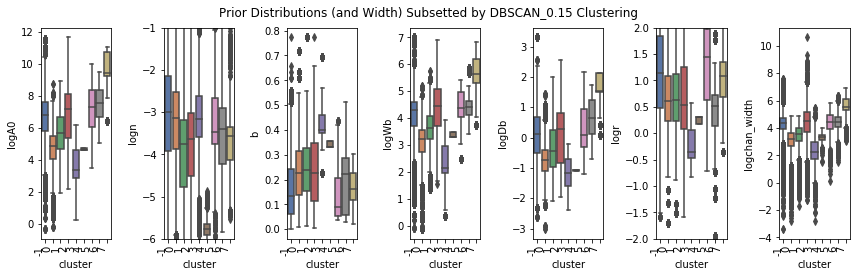

In [16]:
fig, axs = plt.subplots(ncols=7, figsize=(12, 4))
sns.boxplot(x="cluster", y='logA0', data=data, palette='deep', ax=axs[0])
sns.boxplot(x="cluster", y='logn', data=data, palette='deep', ax=axs[1])
sns.boxplot(x="cluster", y='b', data=data, palette='deep', ax=axs[2])
sns.boxplot(x="cluster", y='logWb', data=data, palette='deep', ax=axs[3])
sns.boxplot(x="cluster", y='logDb', data=data, palette='deep', ax=axs[4])
sns.boxplot(x="cluster", y='logr', data=data, palette='deep', ax=axs[5])
sns.boxplot(x="cluster", y='logchan_width', data=data, palette='deep', ax=axs[6])

fig.suptitle("Prior Distributions (and Width) Subsetted by DBSCAN_0.15 Clustering")
fig.autofmt_xdate(rotation=90)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
axs[5].set(ylim=(-2, 2))
axs[1].set(ylim=(-6, -1))

In [36]:
data['logSLOPE'] = np.log(data['SLOPE'])
data['logchan_discharge'] = np.log(data['chan_discharge'])

from sklearn.ensemble import RandomForestClassifier
#temp = data.drop_duplicates('site_no')
X = data[['stdWdth', 'meanWdths']]
y = data['cluster']

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.20, random_state=42)

#validation of model on 20% of dataset reserevd for testing
#clf = RandomForestClassifier(n_estimators=100, random_state=0).fit(X_train, y_train)
#clf.predict(X_test)
#clf.score(X_test, y_test)

#actual training on entire dataset for pepsi testing
clf = RandomForestClassifier(n_estimators=100, random_state=0).fit(X, y)
clf.predict(X)
clf.score(X, y)

,stdWdth,meanWdths
count,372109.000000,372109.000000
mean,0.415825,3.711138
std,0.268137,1.008507
min,0.004514,-0.142629
25%,0.209269,3.021059
50%,0.357609,3.605002
75%,0.550953,4.345654
max,2.083884,7.011365


In [48]:
#because I can't output the trained forest to R, I need to load in pepsi test data here and classify
pepsi = pd.read_csv('forRandomForest.csv', low_memory=False, encoding='latin-1')

pepsi['cluster'] = clf.predict(pepsi[['stdWdth', 'meanWdths']])
pepsi.to_csv('pepsiClassified_ep_20.csv')
pepsi.sort_values('cluster')

,Unnamed: 0,meanWdths,stdWdth,river,cluster
31,32,6.705092,0.933020,Wabash.nc,-1
29,30,7.874589,0.328496,StLawrenceUpstream.nc,-1
3,4,4.727870,0.677765,IowaRiver.nc,-1
6,7,5.479105,0.655214,Kushiyara.nc,-1
7,8,7.176135,0.286365,MississippiDownstream.nc,-1
21,22,5.886637,0.453401,Po.nc,-1
27,28,3.884831,0.174667,Severn.nc,0
19,20,7.079570,0.170229,OhioSection8.nc,2
20,21,6.275339,0.476472,Platte.nc,2
22,23,4.626334,0.259406,SacramentoDownstream.nc,2


<h4> <font color=darkolivegreen> Scratch Stuff </font></h4>